In [ ]:
# default_exp core

# fcst_campaign core module

> Gets forecast from BigQuery, loads campaigns and get historic launches

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
  !pip install timezonefinder
  !pip install google-cloud-bigquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 MB 13.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.8 MB/s eta 0:00:00
  Created wheel for timezonefinder: filename=timezonefinder-6.4.1-cp310-cp310-manylinux_2_35_x86_64.whl size=49040893 sha256=dc924ec6fc10b1071e508d60ff215c2d5b3b28f24c68d5cd56eee88a1df5735f
  Stored in directory: /root/.cache/pip/wheels/52/8f/5f/8ace889092b27a1c13b9fa7582d5763f417c29b9d23388415d
Successfully built timezonefinder


In [ ]:
if IN_COLAB:
  !pip install git+https://github.com/pete88b/nbdev_colab_helper.git
  from nbdev_colab_helper.core import *
  project_name = 'forecast_action'
  init_notebook(project_name)

  Cloning https://github.com/pete88b/nbdev_colab_helper.git to /tmp/pip-req-build-5oeepaxg
  Running command git clone --filter=blob:none --quiet https://github.com/pete88b/nbdev_colab_helper.git /tmp/pip-req-build-5oeepaxg
  Resolved https://github.com/pete88b/nbdev_colab_helper.git to commit 15cf67b6ca0c125a636cedc017f285a04771bbff
  Preparing metadata (setup.py) ... done
  Created wheel for nbdev-colab-helper: filename=nbdev_colab_helper-0.0.1-py3-none-any.whl size=9679 sha256=6c4e92250586d25164f8cb6e2a1f3b40a03d14098d734ed2233971c7f3eaa9b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-_xq2ko6b/wheels/0c/50/90/0c073bb88ab36268043083b5ee7bc3a8b39c1a423c3c3736b7
Successfully built nbdev-colab-helper
Connecting to google drive
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/github/forecast_action
pip install fastscript==1.0.0 fastcore==1.0.8 nbdev==1.0.14
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export
from forecast_action.utils import *

Rounded Coordinates for Chicago: Latitude 42.0, Longitude -87.75
{'lat_lon': (40.7128, -74.006), 'time_zone': 'America/New_York', 'local_peak_start': '2024-03-07 05:00:00', 'local_peak_end': '2024-03-07 12:00:00'}
{'lat_lon': (28.6139, 77.209), 'time_zone': 'Asia/Kolkata', 'local_peak_start': '2024-03-07 15:30:00', 'local_peak_end': '2024-03-07 22:30:00'}
Timezone offset for latitude 40.7128, longitude -74.006 is -5.0 hours.


In [ ]:
# hide
import pytz
import sys
from google.colab import drive
if IN_COLAB:
  drive.mount('/content/drive') #,force_remount=True)

from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import userdata
credentials_path = userdata.get('climada_cred_path')

from timezonefinder import TimezoneFinder
import pytz
from datetime import datetime, timedelta

import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import TimestampedGeoJson

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
do_auth = 0
if do_auth:
  from google.colab import auth
  auth.authenticate_user()
  print('Authenticated')
  project_id = 'climadatutorial'  # Replace with your Google Cloud project ID


In [ ]:
# hide
import gspread
from oauth2client.client import GoogleCredentials
import gspread_dataframe
from gspread_dataframe import get_as_dataframe, set_with_dataframe

from google.auth import default

def get_campaign_details(filn="WeatherAdCampaign",credentials_path=credentials_path):
  #creds, _ = default()
  #gc = gspread.authorize(GoogleCredentials.get_application_default())
  #creds = service_account.Credentials.from_service_account_file(credentials_path)
  # Use service account credentials with explicit scope
  #scopes = ['https://spreadsheets.google.com/feeds']
  scopes = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive.readonly']

  creds = service_account.Credentials.from_service_account_file(credentials_path, scopes=scopes)
  gc = gspread.authorize(creds)
  workbook = gc.open(filn)

  # Reading the 'Company' worksheet
  company_df = get_as_dataframe(workbook.worksheet('Company'), evaluate_formulas=True, usecols=lambda x: x not in [''], dtype=str).dropna(how='all').dropna(axis=1, how='all')
  companies = list(company_df['Company'].unique())

  # Reading the 'Campaigns' worksheet
  campaigns_df = get_as_dataframe(workbook.worksheet('Campaigns'), evaluate_formulas=True, usecols=lambda x: x not in [''], dtype=str).dropna(how='all').dropna(axis=1, how='all')
  ## campaigns_df data is in F, convert to C since the BigQuery is in C
  campaigns_df[['Tmax','Tmin']] = (campaigns_df[['Tmax','Tmin']].astype(float)-32)*5/9
  return company_df, campaigns_df

In [ ]:
company_df, campaigns_df = get_campaign_details()

In [ ]:
# export
def fetch_forecast_data_all(city_lat, city_lon, start_date, end_date, project_id, credentials_path):
    # Construct a BigQuery client object.
    credentials = service_account.Credentials.from_service_account_file(credentials_path)
    client = bigquery.Client(credentials=credentials, project=project_id)

    query = f"""
    WITH daily_forecasts AS (
      SELECT
        creation_time,
        DATE(forecast.time) AS forecast_date,
        MAX(IF(forecast.temperature_2m_above_ground IS NOT NULL, forecast.temperature_2m_above_ground, NULL)) AS max_temp,
        MIN(IF(forecast.temperature_2m_above_ground IS NOT NULL, forecast.temperature_2m_above_ground, NULL)) AS min_temp,
        AVG(IF(forecast.temperature_2m_above_ground IS NOT NULL, forecast.temperature_2m_above_ground, NULL)) AS avg_temp,
        SUM(IF(forecast.total_precipitation_surface IS NOT NULL, forecast.total_precipitation_surface, 0)) AS total_precipitation
      FROM
        `bigquery-public-data.noaa_global_forecast_system.NOAA_GFS0P25`,
        UNNEST(forecast) AS forecast
      WHERE
        creation_time BETWEEN '{start_date}' AND '{end_date}'
        AND ST_DWithin(geography, ST_GeogPoint({city_lon}, {city_lat}), 5000)
      GROUP BY
        creation_time,
        forecast_date
    )
    SELECT
      creation_time,
      forecast_date,
      max_temp,
      min_temp,
      avg_temp,
      total_precipitation
    FROM
      daily_forecasts
    ORDER BY
      creation_time,
      forecast_date
    """

    query_job = client.query(query)  # Make an API request.
    results = query_job.result()  # Wait for the job to complete.

    # Convert to DataFrame
    df = results.to_dataframe()
    return df

# Example usage
project_id = 'climadatutorial'
#credentials_path = '/content/drive/Othercomputers/My PC (1)/Documents/Projects/Code/keys/climadatutorial-051f2156cfbb.json'

city_lat = 40.7128
city_lon = -74.0060
start_date = '2023-07-01'
end_date = '2023-08-31'

#df = fetch_forecast_data(city_lat, city_lon, start_date, end_date, project_id, credentials_path)
#print(df)


In [ ]:
# export
def fetch_forecast_data_lead(city_lat, city_lon, start_date, end_date, project_id, credentials_path, lead_days=3):
    # Construct a BigQuery client object.
    credentials = service_account.Credentials.from_service_account_file(credentials_path)
    client = bigquery.Client(credentials=credentials, project=project_id)

    offset_hour = int(get_timezone_offset(city_lat, city_lon))  # Ensure this function call is correct
    print(offset_hour)

    query = f"""
    WITH daily_forecasts AS (
      SELECT
        creation_time,
        DATE(DATETIME_ADD(forecast.time, INTERVAL {offset_hour} HOUR)) AS local_forecast_date,
        MAX(IF(forecast.temperature_2m_above_ground IS NOT NULL, forecast.temperature_2m_above_ground, NULL)) AS max_temp,
        MIN(IF(forecast.temperature_2m_above_ground IS NOT NULL, forecast.temperature_2m_above_ground, NULL)) AS min_temp,
        AVG(IF(forecast.temperature_2m_above_ground IS NOT NULL, forecast.temperature_2m_above_ground, NULL)) AS avg_temp,
        SUM(IF(forecast.total_precipitation_surface IS NOT NULL, forecast.total_precipitation_surface, 0)) AS total_precipitation,
        AVG(IF(TIME(DATETIME_ADD(forecast.time, INTERVAL {offset_hour} HOUR)) BETWEEN '10:00:00' AND '17:00:00' AND forecast.total_cloud_cover_entire_atmosphere IS NOT NULL, forecast.total_cloud_cover_entire_atmosphere, NULL)) AS avg_cloud_cover,
        CASE
          WHEN AVG(forecast.temperature_2m_above_ground) < 32 THEN SUM(IF(forecast.total_precipitation_surface IS NOT NULL, forecast.total_precipitation_surface, 0))
          ELSE 0
        END AS total_snow,
        CASE
          WHEN AVG(forecast.temperature_2m_above_ground) >= 32 THEN SUM(IF(forecast.total_precipitation_surface IS NOT NULL, forecast.total_precipitation_surface, 0))
          ELSE 0
        END AS total_rain
      FROM
        `bigquery-public-data.noaa_global_forecast_system.NOAA_GFS0P25`,
        UNNEST(forecast) AS forecast
      WHERE
        creation_time BETWEEN '{start_date}' AND '{end_date}'
        AND ST_DWithin(geography, ST_GeogPoint({city_lon}, {city_lat}), 5000)
        AND DATE(forecast.time) = DATE_ADD(DATE(creation_time), INTERVAL {lead_days} DAY)
      GROUP BY
        creation_time,
        local_forecast_date
    )
    SELECT
      creation_time,
      local_forecast_date AS forecast_date,
      max_temp,
      min_temp,
      avg_temp,
      total_precipitation,
      avg_cloud_cover,
      total_snow,
      total_rain
    FROM
      daily_forecasts
    ORDER BY
      creation_time,
      local_forecast_date
    """

    query_job = client.query(query)  # Make an API request.
    results = query_job.result()  # Wait for the job to complete.

    # Convert to DataFrame
    df = results.to_dataframe()
    return df


In [ ]:
# export

def fetch_forecast_data_lead2(city_lat, city_lon, start_date, end_date, project_id, credentials_path, lead_days=3,round2grid=1):
    # Assuming offset_hour is correctly calculated earlier in the function
    offset_hour = int(get_timezone_offset(city_lat, city_lon))  # Placeholder for actual timezone offset calculation
    # Construct a BigQuery client object.
    credentials = service_account.Credentials.from_service_account_file(credentials_path)
    client = bigquery.Client(credentials=credentials, project=project_id)

    # If you decided to round the lat,lon to the grid of the source data
    # this increases the chance of matching - but the rounding might create error
    # and you need to confirm the grid resolution - default is 0.25,0.25
    city_lat, city_lon =  round_to_grid(city_lat, city_lon)

    query = f"""
    WITH forecast_adjustments AS (
      SELECT
        creation_time,
        forecast.time AS utc_forecast_time,
        DATETIME_ADD(forecast.time, INTERVAL {offset_hour} HOUR) AS local_forecast_time,
        DATE(DATETIME_ADD(forecast.time, INTERVAL {offset_hour} HOUR)) AS local_forecast_date,
        forecast.temperature_2m_above_ground,
        forecast.relative_humidity_2m_above_ground,
        forecast.total_precipitation_surface,
        forecast.total_cloud_cover_entire_atmosphere
      FROM
        `bigquery-public-data.noaa_global_forecast_system.NOAA_GFS0P25`,
        UNNEST(forecast) AS forecast
      WHERE
        creation_time BETWEEN '{start_date}' AND '{end_date}'
        AND ST_DWithin(geography, ST_GeogPoint({city_lon}, {city_lat}), 5000)
    ),
    target_forecasts AS (
      SELECT
        creation_time,
        local_forecast_date,
        local_forecast_time,
        temperature_2m_above_ground,
        relative_humidity_2m_above_ground,
        total_precipitation_surface,
        total_cloud_cover_entire_atmosphere,
        DATE(DATETIME_ADD(creation_time, INTERVAL {lead_days * 24} HOUR)) AS target_date
      FROM forecast_adjustments
    ),
    day_aggregates AS (
      SELECT
        creation_time,
        local_forecast_date,
        MAX(temperature_2m_above_ground) AS max_temp,
        MIN(temperature_2m_above_ground) AS min_temp,
        AVG(temperature_2m_above_ground) AS avg_temp,
        AVG(relative_humidity_2m_above_ground) AS avg_rh,
        SUM(total_precipitation_surface) AS total_precipitation,
        SUM(CASE WHEN temperature_2m_above_ground < 0 THEN total_precipitation_surface ELSE 0 END) AS total_snow,
        SUM(CASE WHEN temperature_2m_above_ground >= 0 THEN total_precipitation_surface ELSE 0 END) AS total_rain,
        AVG(CASE WHEN EXTRACT(HOUR FROM local_forecast_time) BETWEEN 10 AND 17 THEN total_cloud_cover_entire_atmosphere ELSE NULL END) AS avg_cloud_cover
      FROM target_forecasts
      WHERE local_forecast_date = target_date
      GROUP BY creation_time, local_forecast_date
    )
    SELECT
      creation_time,
      local_forecast_date,
      max_temp,
      min_temp,
      avg_temp,
      avg_rh,
      total_precipitation,
      total_snow,
      total_rain,
      avg_cloud_cover
    FROM day_aggregates
    ORDER BY creation_time, local_forecast_date
    """

    query_job = client.query(query)  # Make an API request.
    results = query_job.result()  # Wait for the job to complete.

    # Convert to DataFrame
    df = results.to_dataframe()
    return df


In [ ]:
forecast_df = fetch_forecast_data_lead2(city_lat, city_lon, start_date, end_date, project_id, credentials_path)
forecast_df.head(10)

,creation_time,local_forecast_date,max_temp,min_temp,avg_temp,avg_rh,total_precipitation,total_snow,total_rain,avg_cloud_cover
0,2023-07-01 00:00:00,2023-07-04,33.636377,21.482416,27.699541,57.312501,2.000,0.0,2.000,3.062500
1,2023-07-01 06:00:00,2023-07-04,34.072137,22.787500,28.433823,52.829167,0.500,0.0,0.500,3.300000
2,2023-07-01 12:00:00,2023-07-04,31.505914,23.195093,27.591867,61.966667,0.625,0.0,0.625,78.925001
3,2023-07-01 18:00:00,2023-07-04,33.302881,21.477258,27.763382,55.500000,1.750,0.0,1.750,41.275001
4,2023-07-02 00:00:00,2023-07-05,34.303217,24.185480,28.827465,50.050001,0.125,0.0,0.125,3.925000
5,2023-07-02 06:00:00,2023-07-05,33.931268,23.497369,28.545306,56.841668,0.125,0.0,0.125,7.562500
6,2023-07-02 12:00:00,2023-07-05,33.164880,22.367548,27.102010,63.066668,0.625,0.0,0.625,0.350000
7,2023-07-02 18:00:00,2023-07-05,33.312402,22.099939,26.845469,66.150001,0.000,0.0,0.000,9.087500
8,2023-07-03 00:00:00,2023-07-06,30.525842,23.620477,26.110365,67.133334,0.750,0.0,0.750,5.100000
9,2023-07-03 06:00:00,2023-07-06,30.987512,24.114252,26.880591,63.937501,0.875,0.0,0.875,33.587500


In [ ]:
# export

def evaluate_campaign_trigger(forecast_row, campaign_row):
    # Temperature criteria
    temp_triggered = True  # Default to True if no temperature criteria
    if pd.notna(campaign_row['Tmin']):
        temp_triggered &= (forecast_row['max_temp'] >= float(campaign_row['Tmin']))
    if pd.notna(campaign_row['Tmax']):
        temp_triggered &= (forecast_row['max_temp'] <= float(campaign_row['Tmax']))

    # Precipitation criteria
    precip_triggered = True  # Default to True if no precipitation criteria
    if pd.notna(campaign_row['Pmin']):
        precip_triggered &= (forecast_row['total_precipitation'] >= float(campaign_row['Pmin']))
    if pd.notna(campaign_row['Pmax']):
        precip_triggered &= (forecast_row['total_precipitation'] <= float(campaign_row['Pmax']))

    # Snow criteria
    snow_triggered = True  # Default to True if no precipitation criteria
    if pd.notna(campaign_row['Snowmin']):
        snow_triggered &= (forecast_row['total_snow'] >= float(campaign_row['Snowmin']))
    if pd.notna(campaign_row['Snowmax']):
        precip_triggered &= (forecast_row['total_snow'] <= float(campaign_row['Snowmax']))

    # Relative Humidity (RHmax) criteria
    # Assuming RHmax means the campaign triggers if RH is less than RHmax
    rh_triggered = True  # Default to True if no RH criteria
    if pd.notna(campaign_row['RHmin']):
        # Placeholder for RH comparison, assuming you have RH data
        rh_triggered &= (forecast_row['avg_rh'] > float(campaign_row['RHmin']))  # Placeholder for actual RH data
    if pd.notna(campaign_row['RHmax']):
        # Placeholder for RH comparison, assuming you have RH data
        rh_triggered &= (forecast_row['avg_rh'] <= float(campaign_row['RHmax']))  # Placeholder for actual RH data

    # Sunlight (Sun) criteria
    # Assuming Sun criteria means a certain threshold of sunlight, like avg_cloud_cover < threshold
    sun_triggered = True  # Default to True if no Sun criteria
    if pd.notna(campaign_row['Sun']):
        # Placeholder for sunlight comparison
        sun_triggered &= (forecast_row['avg_cloud_cover'] < float(campaign_row['Sun']))  # Assuming lower cloud cover means more sunlight

    # Combine all criteria
    campaign_triggered = temp_triggered & precip_triggered & rh_triggered & sun_triggered & snow_triggered
    return campaign_triggered

In [ ]:

# Example application of the function
for index, campaign_row in campaigns_df.iterrows():
    forecast_df[f'campaign_triggered_{index}'] = forecast_df.apply(evaluate_campaign_trigger, axis=1, campaign_row=campaign_row)

# This will add columns to forecast_df indicating whether each campaign is triggered for each forecast entry


In [ ]:
forecast_df.head(10)

,creation_time,local_forecast_date,max_temp,min_temp,avg_temp,avg_rh,total_precipitation,total_snow,total_rain,avg_cloud_cover,campaign_triggered_0,campaign_triggered_1,campaign_triggered_2,campaign_triggered_3,campaign_triggered_4,campaign_triggered_5,campaign_triggered_6
0,2023-07-01 00:00:00,2023-07-04,33.636377,21.482416,27.699541,57.312501,2.000,0.0,2.000,3.062500,False,False,False,False,True,True,False
1,2023-07-01 06:00:00,2023-07-04,34.072137,22.787500,28.433823,52.829167,0.500,0.0,0.500,3.300000,True,False,False,False,True,True,True
2,2023-07-01 12:00:00,2023-07-04,31.505914,23.195093,27.591867,61.966667,0.625,0.0,0.625,78.925001,True,False,False,False,False,True,True
3,2023-07-01 18:00:00,2023-07-04,33.302881,21.477258,27.763382,55.500000,1.750,0.0,1.750,41.275001,False,False,False,False,True,True,False
4,2023-07-02 00:00:00,2023-07-05,34.303217,24.185480,28.827465,50.050001,0.125,0.0,0.125,3.925000,True,False,False,False,True,True,True
5,2023-07-02 06:00:00,2023-07-05,33.931268,23.497369,28.545306,56.841668,0.125,0.0,0.125,7.562500,True,False,False,False,True,True,True
6,2023-07-02 12:00:00,2023-07-05,33.164880,22.367548,27.102010,63.066668,0.625,0.0,0.625,0.350000,True,False,False,False,True,True,True
7,2023-07-02 18:00:00,2023-07-05,33.312402,22.099939,26.845469,66.150001,0.000,0.0,0.000,9.087500,True,False,False,False,True,True,True
8,2023-07-03 00:00:00,2023-07-06,30.525842,23.620477,26.110365,67.133334,0.750,0.0,0.750,5.100000,True,False,False,False,True,True,True
9,2023-07-03 06:00:00,2023-07-06,30.987512,24.114252,26.880591,63.937501,0.875,0.0,0.875,33.587500,True,False,False,False,True,True,True


In [ ]:
# export

def assign_ad_type(forecast_row, campaigns_df):
  # Function to assign AdType to each forecast entry based on the first triggered campaign

  for _, campaign_row in campaigns_df.iterrows():
      if evaluate_campaign_trigger(forecast_row, campaign_row):
          return campaign_row['AdType']
  return None

In [ ]:
# export

def get_campaign_hist(company_sel = 'BigAssFans'):
  ## Do this for a company, consolidate campaign per city

  comp_row = company_df[company_df['Company']==company_sel].iloc[-1,:]  # picking the last entry of this comany in the df - incase there are multiple entries
  camp_sel = campaigns_df[campaigns_df['Company']==company_sel]
  lat_lon_list,city_names = create_geo_query_list(company_df, company_sel)
  city_locations = dict(zip(city_names,lat_lon_list))

  # Initialize city_res_df with creation_time from forecast_df of the first city as a starting point
  first_city_lat, first_city_lon = lat_lon_list[0]
  first_forecast_df = fetch_forecast_data_lead2(first_city_lat, first_city_lon, start_date, end_date, project_id, credentials_path)
  city_res_df = pd.DataFrame(first_forecast_df['creation_time']).drop_duplicates().reset_index(drop=True)

  for ((city_lat,city_lon),city_name) in zip(lat_lon_list,city_names):
    forecast_df = fetch_forecast_data_lead2(city_lat, city_lon, start_date, end_date, project_id, credentials_path)
    # Example application of the function
    # Assuming campaigns_df is already filtered for a specific company
    forecast_df['AdType'] = forecast_df.apply(assign_ad_type, axis=1, campaigns_df=camp_sel)
    # Merge on 'creation_time' to align data
    merged_df = city_res_df.merge(forecast_df[['creation_time', 'AdType']], on='creation_time', how='left')
    merged_df.rename(columns={'AdType': city_name}, inplace=True)
    city_res_df = merged_df

  return city_res_df, city_locations

In [ ]:
city_res_df, city_locations = get_campaign_hist(company_sel = 'BigAssFans')

USA


In [ ]:
# export


def campaign_heatmap(city_res_df):
  # Assuming city_res_df is your DataFrame

  # Convert 'creation_time' to a datetime type if it's not already
  city_res_df['creation_time'] = pd.to_datetime(city_res_df['creation_time']).dt.strftime('%Y-%m-%dT%HZ')

  # Melt the DataFrame to long format for easier plotting with seaborn
  df_long = city_res_df.melt(id_vars=['creation_time'], var_name='City', value_name='AdType')

  # Remove rows where AdType is None
  df_long = df_long.dropna(subset=['AdType'])

  # Create a heat map
  plt.figure(figsize=(12, 6))
  heatmap = sns.heatmap(data=pd.pivot_table(df_long, values='AdType', index=['City'], columns=['creation_time'], aggfunc=lambda x: 1),
                        cmap="crest", cbar=False)

  heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
  #plt.xticks(locator=plt.MaxNLocator(5))
  plt.locator_params(axis='x', nbins=20)
  plt.title('Ad Display Schedule by City and Time')
  plt.show()


Rounded Coordinates for Chicago: Latitude 42.0, Longitude -87.75
{'lat_lon': (40.7128, -74.006), 'time_zone': 'America/New_York', 'local_peak_start': '2024-03-07 05:00:00', 'local_peak_end': '2024-03-07 12:00:00'}
{'lat_lon': (28.6139, 77.209), 'time_zone': 'Asia/Kolkata', 'local_peak_start': '2024-03-07 15:30:00', 'local_peak_end': '2024-03-07 22:30:00'}
Timezone offset for latitude 40.7128, longitude -74.006 is -5.0 hours.


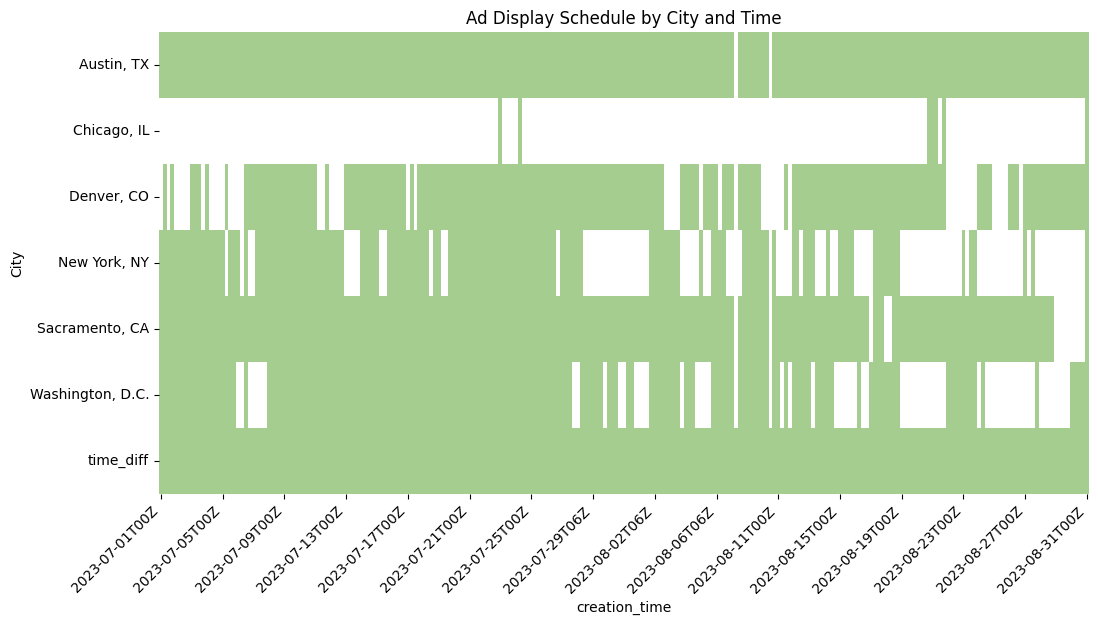

In [ ]:
campaign_heatmap(city_res_df)

In [ ]:
# export

def create_map(data):
  # Create a map for this time step
  m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
  # Add markers to map using GeoJSON
  folium.GeoJson(data, name="Ad Campaigns").add_to(m)
  return m

data = {
  'type': 'FeatureCollection',
  'features': []
}

def map_campaigns_by_day(city_res_df,city_locations,suff=''):
  ## Map of selected day and the various campaigns to be run..
  # Ensure 'creation_time' includes the date and hour in ISO 8601 format
  city_res_df['creation_time'] = pd.to_datetime(city_res_df['creation_time']).dt.strftime('%Y-%m-%dT%H:00:00Z')
  import folium
  from folium.plugins import TimestampedGeoJson

  '''
  # Define city locations (replace with your actual data)
  city_locations = {
      'Washington, D.C.': (38.9072, -77.0369),
      'Austin, TX': (30.2672, -97.7431),
      'Sacramento, CA': (38.5816, -121.4944),
      'New York, NY': (40.7128, -74.0060),
      'Chicago, IL': (41.8781, -87.6298),
      'Denver, CO': (39.7392, -104.9903)
  }
  '''
  # Existing loop to create features
  for index, row in city_res_df.iterrows():
    for city, ad_type in row.items():
      if city == 'creation_time':
        continue  # Skip the creation_time column itself
      if city in city_locations:
        feature = {
          'type': 'Feature',
          'geometry': {
            'type': 'Point',
            'coordinates': [city_locations[city][1], city_locations[city][0]],
          },
          'properties': {
            'time': row['creation_time'],  # Now includes the hour
            'ad_type': ad_type,  # This line is added
            'icon': 'circle',
            'iconstyle': {
              'fillColor': '#ffffff' if ad_type is None else '#0078A8',  # White for None, blue otherwise
              'fillOpacity': 1,  # Always fully opaque
              'stroke': 'true',
              'radius': 7,
            },
            'popup': city,
          },
        }
        data['features'].append(feature)

  # Create a map for the first time step and add TimestampedGeoJson
  map = create_map(data.copy())  # Copy data to avoid modification
  ts_geojson = TimestampedGeoJson(data, period='PT6H', add_last_point=False).add_to(map)

  # Save the map as HTML
  outfiln = 'ads_over_time'+suff+'.html'
  map.save(outfiln)
  print(f"Map saved to {outfiln}")

  return


Rounded Coordinates for Chicago: Latitude 42.0, Longitude -87.75
{'lat_lon': (40.7128, -74.006), 'time_zone': 'America/New_York', 'local_peak_start': '2024-03-07 05:00:00', 'local_peak_end': '2024-03-07 12:00:00'}
{'lat_lon': (28.6139, 77.209), 'time_zone': 'Asia/Kolkata', 'local_peak_start': '2024-03-07 15:30:00', 'local_peak_end': '2024-03-07 22:30:00'}
Timezone offset for latitude 40.7128, longitude -74.006 is -5.0 hours.


In [ ]:
map_campaigns_by_day(city_res_df,city_locations)

Map saved to ads_over_time.html


In [ ]:
## Show some summary stats of # of Ads of each type by City, and a time series by city
## of days campaign is run and % of time

In [ ]:
# export

def get_campaign_summary():
  # Assuming city_res_df is your DataFrame and it's already sorted by 'creation_time'
  city_res_df['creation_time'] = pd.to_datetime(city_res_df['creation_time'])

  # Calculate the time difference between consecutive entries
  city_res_df['time_diff'] = city_res_df['creation_time'].diff().dt.total_seconds().fillna(0)

  # Example duration of each entry (assuming hourly intervals if not directly calculable)
  # If your intervals are consistent but not hourly, adjust 'time_diff' calculation accordingly
  #hourly_interval_seconds = 3600
  #city_res_df['time_diff'].replace(0, hourly_interval_seconds, inplace=True)

  # Initialize a dictionary to store the total duration each ad campaign runs in each city
  duration_per_ad_per_city = {city: {} for city in city_res_df.columns if city != 'creation_time' and city != 'time_diff'}

  # Calculate the total duration for each ad type in each city
  for city in duration_per_ad_per_city.keys():
      # Group by ad type and sum the duration
      ad_durations = city_res_df.groupby(city)['time_diff'].sum()
      duration_per_ad_per_city[city] = ad_durations.to_dict()

  # Calculate the total observed time
  total_time = city_res_df['time_diff'].sum()

  # Calculate the percentage of total time for each ad campaign in each city
  percentage_per_ad_per_city = {city: {ad: (duration / total_time * 100) for ad, duration in durations.items()} for city, durations in duration_per_ad_per_city.items()}

  # Example output
  print("Duration per ad per city (in seconds):")
  print(duration_per_ad_per_city)
  print("\nPercentage of total time per ad per city:")
  print(percentage_per_ad_per_city)
  return duration_per_ad_per_city,percentage_per_ad_per_city


In [ ]:
duration_per_ad_per_city,percentage_per_ad_per_city = get_campaign_summary()

Duration per ad per city (in seconds):
{'Washington, D.C.': {'CoolingFanAd': 3801600.0}, 'Austin, TX': {'CoolingFanAd': 5227200.0}, 'Sacramento, CA': {'CoolingFanAd': 4989600.0}, 'New York, NY': {'CoolingFanAd': 3088800.0}, 'Chicago, IL': {'CoolingFanAd': 151200.0}, 'Denver, CO': {'CoolingFanAd': 4212000.0}}

Percentage of total time per ad per city:
{'Washington, D.C.': {'CoolingFanAd': 72.1311475409836}, 'Austin, TX': {'CoolingFanAd': 99.18032786885246}, 'Sacramento, CA': {'CoolingFanAd': 94.67213114754098}, 'New York, NY': {'CoolingFanAd': 58.606557377049185}, 'Chicago, IL': {'CoolingFanAd': 2.8688524590163933}, 'Denver, CO': {'CoolingFanAd': 79.91803278688525}}


In [ ]:
#nbdev this, github and streamlit it.

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Rounded Coordinates for Chicago: Latitude 42.0, Longitude -87.75
{'lat_lon': (40.7128, -74.006), 'time_zone': 'America/New_York', 'local_peak_start': '2024-03-07 05:00:00', 'local_peak_end': '2024-03-07 12:00:00'}
{'lat_lon': (28.6139, 77.209), 'time_zone': 'Asia/Kolkata', 'local_peak_start': '2024-03-07 15:30:00', 'local_peak_end': '2024-03-07 22:30:00'}
Timezone offset for latitude 40.7128, longitude -74.006 is -5.0 hours.
Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted index.ipynb.
